# Random Forest Regressor (Petrophysical Properties).

* **Autor:** Rodrigo Lopez Aburto
* **Versión:** 1.0
* **Fecha:** Diciembre 2023

## Summary

The present notebook follows the data preparation, training, testing and implementation of Random Forest methods for the prediction of Petrophysical properties using well logs. Well logs data, Electrofacieses and user-defined functions are loaded into the notebook; exploratory data analysis is conducted in three stages, aiming to ensure quality and identify data characteristics.

Data standardisation was conducted before the data set splitting process; four different Random Forest algorithms were trained and tuned using the Electrofacieses estimated during the clustering analysis process to control and subdivide the regression process into four models, each aimed to estimate the total porosity in each one of the Electrofacieses.

Once the regressors have been trained, validation is conducted using data from new wells with known properties to demonstrate the quality of the regression and provide metrics for each of the well's predictions.

### Libraries

In [1]:
## Standard Libraries.
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import mode
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from scipy.stats import pearsonr

## Data visualization libraries.
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.image as image
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)

## Data science libraries.
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


## Random forest libraries.
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor

## Metric libraries.
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

**Functions**

In [2]:
from Funciones.GraphStatEng import *
from Funciones.RF_Batch import *

### Data import.

Data from 19 wells was loaded (well logs, petrophysical properties and Electrofacieses) into a pd.DataFrame. Additionally, well-head locations were loaded; these were necessary to conduct the spatial statistical analysis.

In [3]:
Loaded_Data = ['Well_ID','DEPT','ECGR','RHOZ','DTCO','NPHI','PoroFluido','Electrofacies_Class']
well_logs = ['ECGR','RHOZ','DTCO','NPHI']
petrophysic_properties = ['PoroFluido']

In [4]:
currdir = os.getcwd()
df_CHTC = pd.read_csv(currdir + '\\Datos\\Electrofacies_Predicted.csv', 
                            usecols=Loaded_Data, low_memory=False, na_values=-999.25)
df_WellHeads = pd.read_csv(currdir + '\\Datos\\Well_Heads.csv', low_memory=False, na_values=-999.25)

In [5]:
print('%i samples were loaded' %df_CHTC.shape[0])

75238 samples were loaded


In [6]:
pd.options.display.float_format = '{:.5f}'.format

In [7]:
Target_log = 'PoroFluido'

## Exploratory data analysis.

Aiming to understand better the behaviour and relationships between the well logs, and the Electrofacieses, an exploratory analysis was conducted. The analysis provided insight regarding between "A" wells and "C" wells, their spatial distribution and the relationship between the well logs (predictor variables) and the petrophysical properties (target variables); in this case, the analysis was conducted for the total porosity (PHIT).

In [8]:
Wells = list(df_CHTC['Well_ID'].value_counts(sort=False).index)
A_Wells = [x for x in Wells if x.startswith('A')]
C_Wells = [x for x in Wells if x.startswith('C')]
Well_Group = [1 if x.startswith('A')  else 2 for x in df_CHTC['Well_ID']]
df_Well_Group = pd.DataFrame(Well_Group, columns=['Well_Group'], index=df_CHTC.index)

**Univatiate analysis**

A boxplot separated by the Electrofacieses was done looking to ensure the Electrofacieses were clearly defined along the well logs.

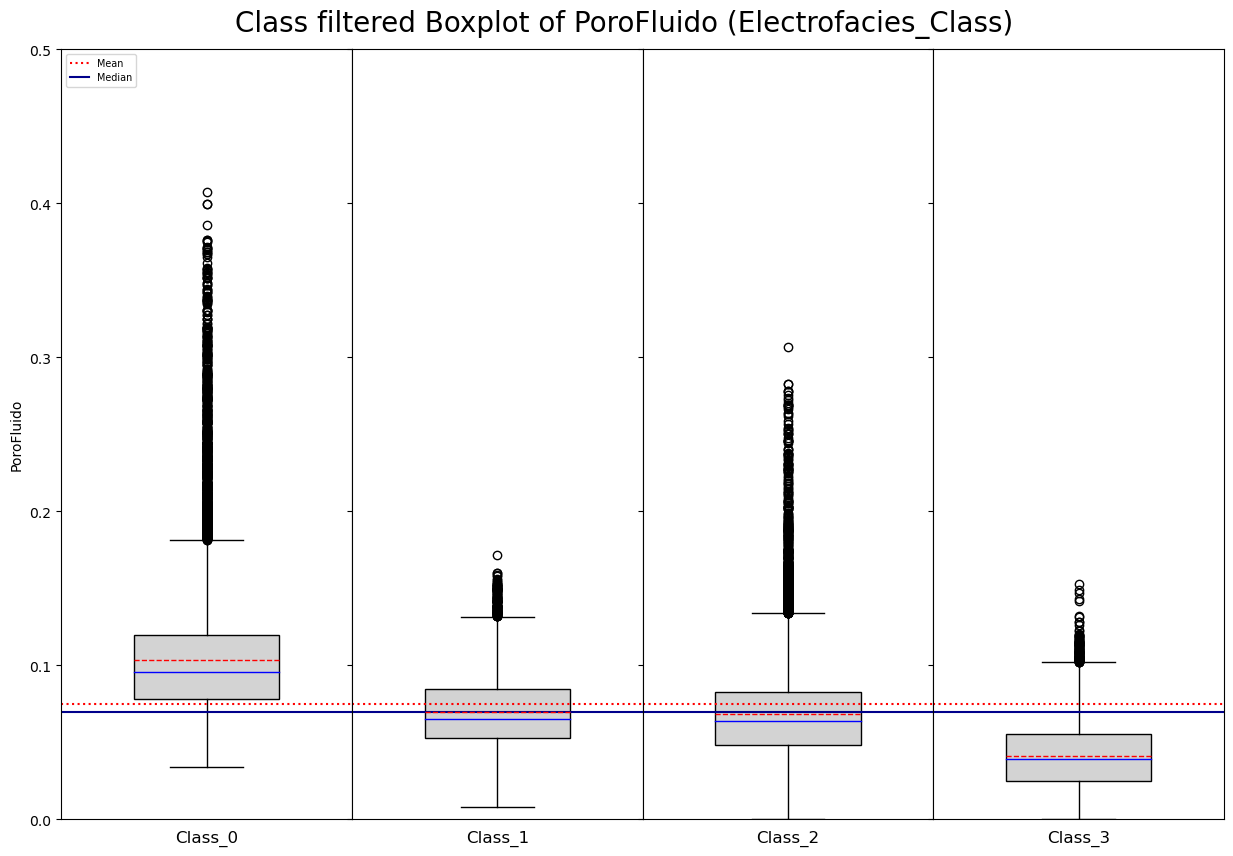

In [9]:
fig, ax = Class_Boxplots(df_CHTC,'PoroFluido', 'Electrofacies_Class',Limits=[0,0.5], figsize=[15,10],median=True,mean=True)

In [10]:
Contar_Clases(df_CHTC, 'Electrofacies_Class').round(2)

,Electrofacies_Class,COUNT,PERCENT
0,0,20548,27.31000
1,1,25571,33.99000
2,2,20147,26.78000
3,3,8972,11.92000


A comparison between the statistics for the 'A' wells (Class_1) and 'C' wells (Class_2) was conducted. The boxplots and statistics are presented to ensure both subsets are similar enough to keep working with them together.

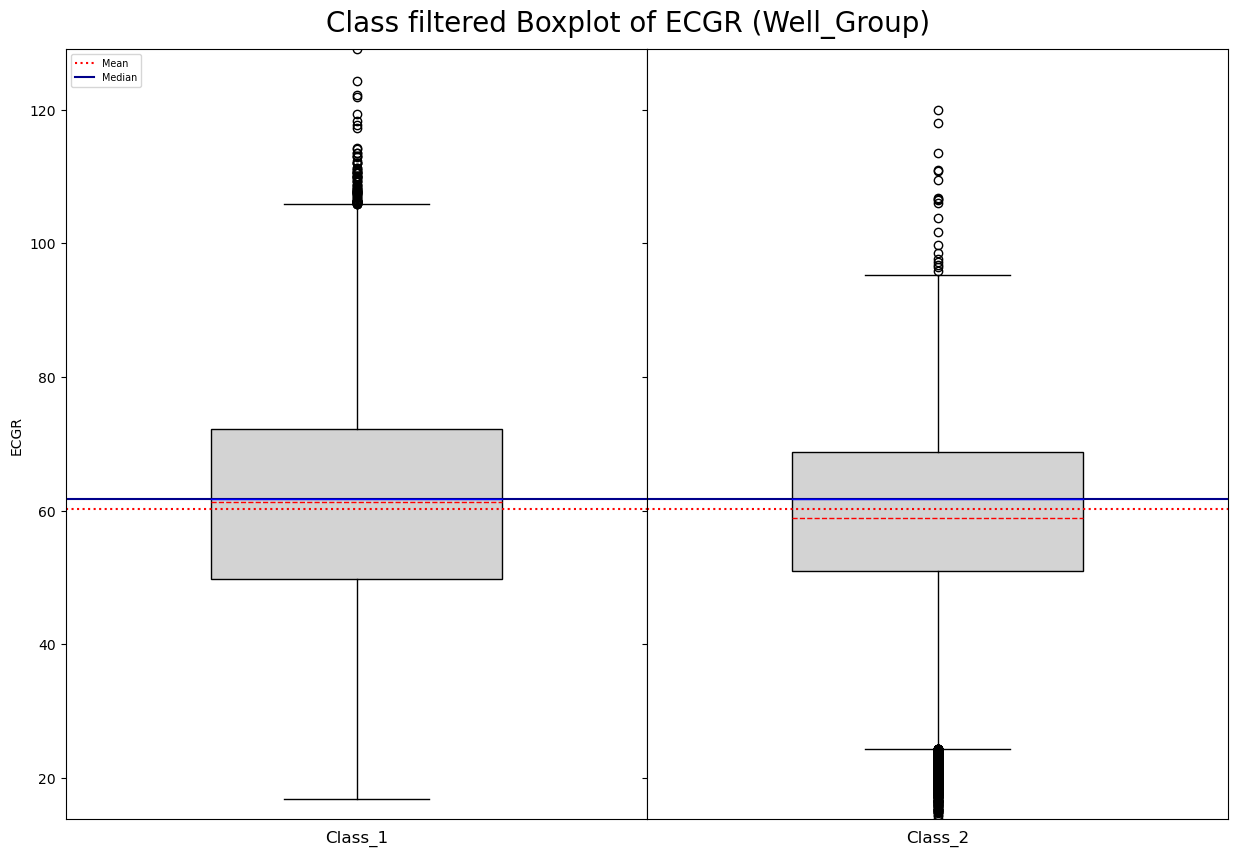

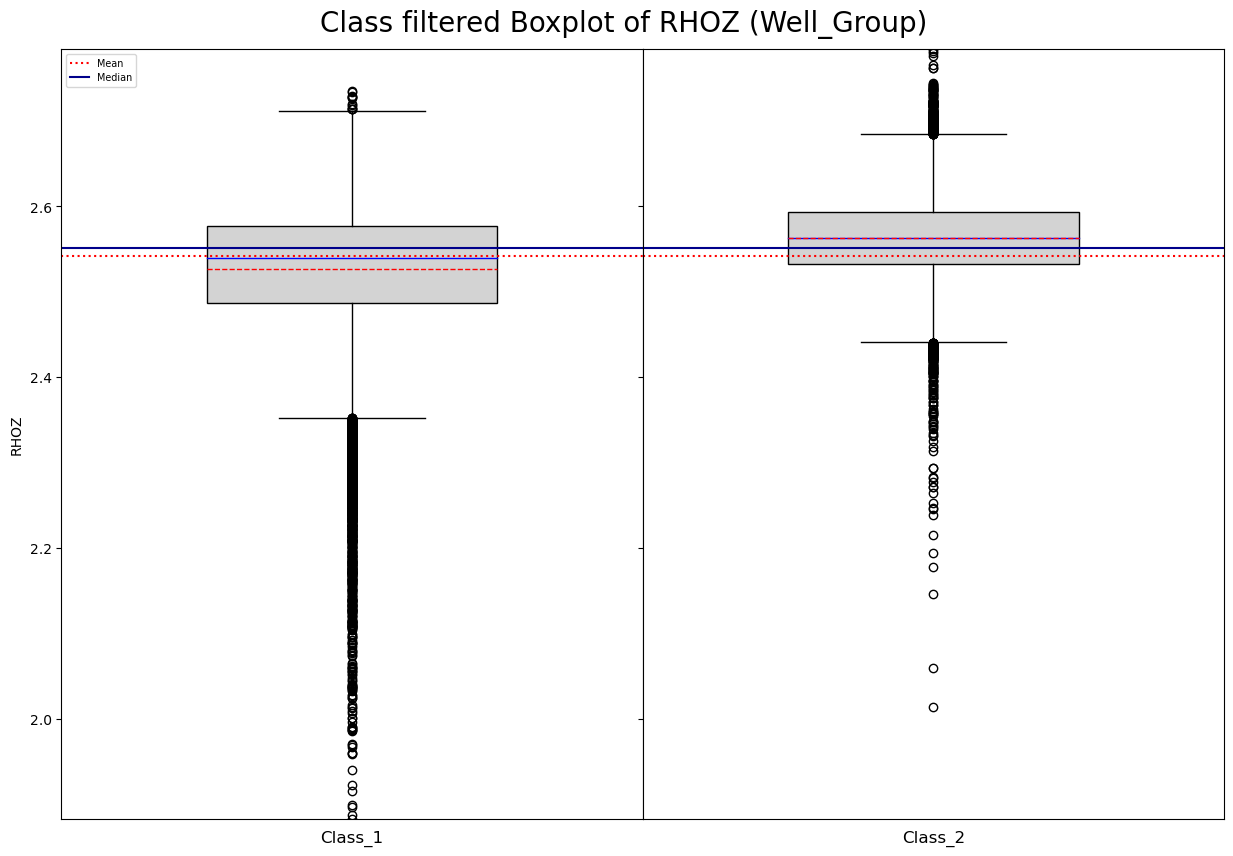

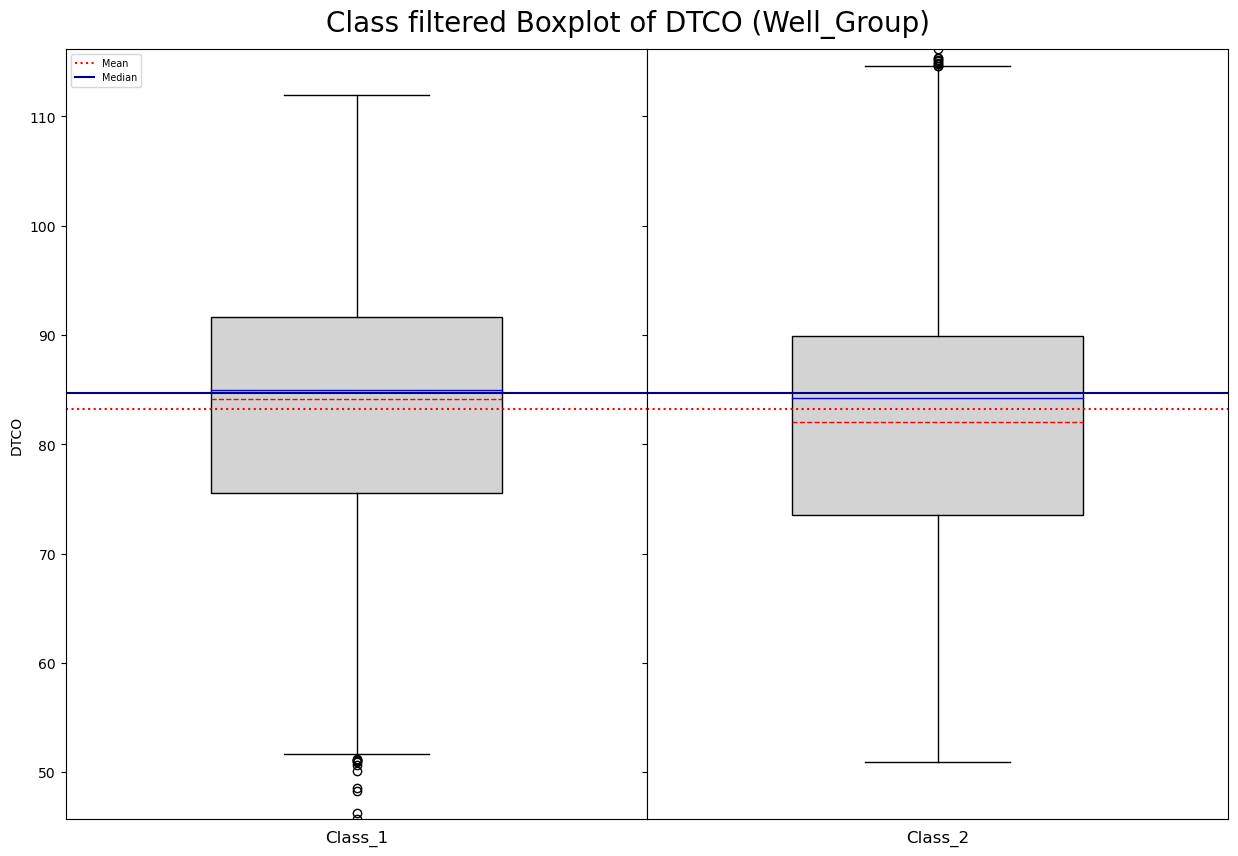

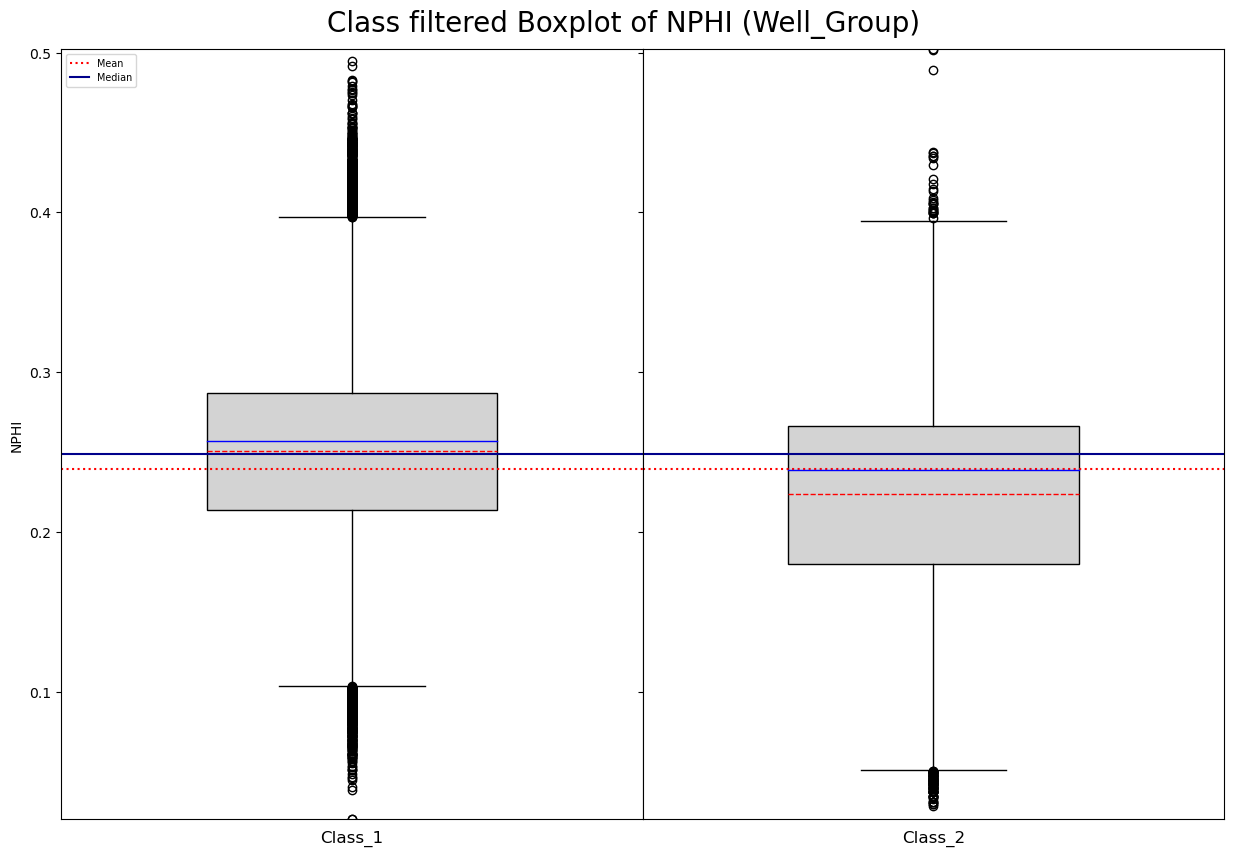

In [11]:
for log in well_logs:
    #fig, ax = Plot_Hist(df_CHTC[df_CHTC['Well'].isin(AGF_Wells)][log], 7, units='dec', size=10)
    fig, ax = Class_Boxplots(df_CHTC.join(df_Well_Group),log, 'Well_Group',
                             figsize=[15,10],median=True,mean=True)
    fig

**Statistics for A wells**

In [12]:
Estadigrafos(df_CHTC[df_CHTC['Well_ID'].isin(A_Wells)],['ECGR','RHOZ','DTCO','NPHI','PoroFluido']).round(2)

,ECGR,RHOZ,DTCO,NPHI,PoroFluido
Samples,42718.00000,42718.00000,42718.00000,42718.00000,42718.00000
Minimum,16.90000,1.88000,45.69000,0.02000,0.00000
1st quartile,49.71000,2.49000,75.50000,0.21000,0.06000
Median,61.71000,2.54000,84.97000,0.26000,0.08000
Mean,61.24000,2.53000,84.11000,0.25000,0.09000
3rd quartile,72.15000,2.58000,91.64000,0.29000,0.11000
Maximum,129.00000,2.74000,112.00000,0.49000,0.41000
Range,112.10000,0.85000,66.31000,0.47000,0.41000
IQR,22.45000,0.09000,16.14000,0.07000,0.05000
Variance,262.22000,0.01000,113.19000,0.00000,0.00000


**Statistics for Coapechaca wells**

In [13]:
Estadigrafos(df_CHTC[df_CHTC['Well_ID'].isin(C_Wells)],['ECGR','RHOZ','DTCO','NPHI','PoroFluido']).round(2)

,ECGR,RHOZ,DTCO,NPHI,PoroFluido
Samples,32520.00000,32520.00000,32520.00000,32520.00000,32520.00000
Minimum,13.81000,2.01000,50.96000,0.03000,0.00000
1st quartile,51.00000,2.53000,73.50000,0.18000,0.05000
Median,61.77000,2.56000,84.27000,0.24000,0.06000
Mean,58.96000,2.56000,82.07000,0.22000,0.06000
3rd quartile,68.76000,2.59000,89.95000,0.27000,0.08000
Maximum,119.92000,2.78000,116.14000,0.50000,0.35000
Range,106.11000,0.77000,65.19000,0.47000,0.35000
IQR,17.76000,0.06000,16.45000,0.09000,0.03000
Variance,188.72000,0.00000,112.06000,0.00000,0.00000


**Bivariate analysis**

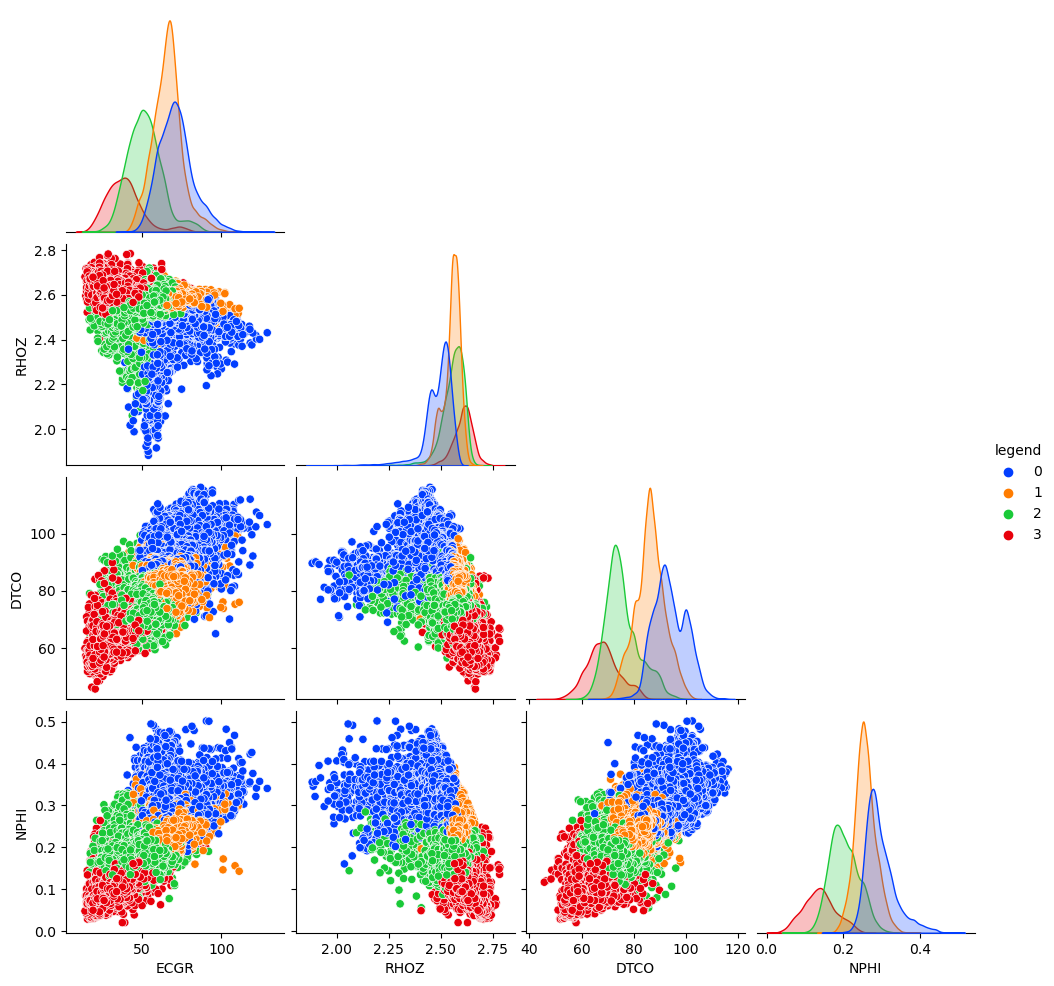

In [14]:
data = df_CHTC[well_logs].copy()
data['legend'] = df_CHTC['Electrofacies_Class']
fig = sns.pairplot(data, hue='legend', palette='bright',diag_kind='kde', corner=True)

In [15]:
Kendall_Coeficients = []
Pearson_Coeficients = []
Spearman_Coeficients = []
for log in well_logs:
    Kendall_Coeficients.append(kendalltau(df_CHTC[log],df_CHTC[Target_log])[0])
    Pearson_Coeficients.append(pearsonr(df_CHTC[log],df_CHTC[Target_log])[0])
    Spearman_Coeficients.append(spearmanr(df_CHTC[log],df_CHTC[Target_log])[0])
df_CCoefficients = pd.DataFrame([Kendall_Coeficients, Pearson_Coeficients, Spearman_Coeficients],
                                index=['Kendall','Pearson','Spearman'],
                                columns=['ECGR','RHOZ','DTCO','NPHI'])
df_CCoefficients

,ECGR,RHOZ,DTCO,NPHI
Kendall,0.24539,-0.84656,0.44271,0.42146
Pearson,0.32078,-0.96550,0.54147,0.55053
Spearman,0.35514,-0.94979,0.61607,0.59027


**Spatial analysis**

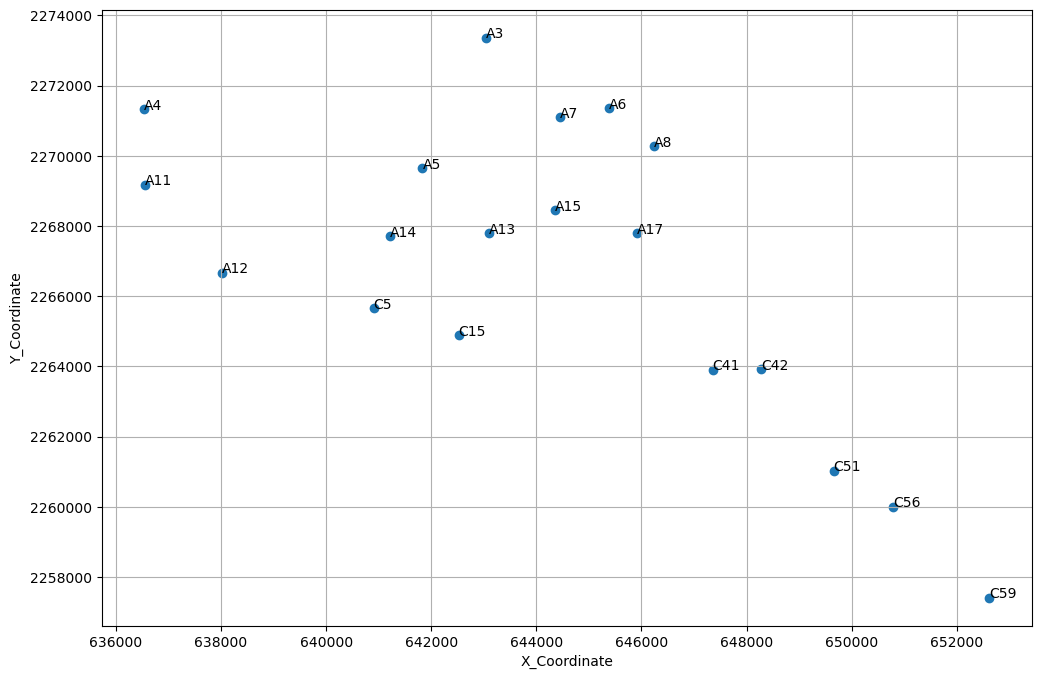

In [16]:
fig, ax = plt.subplots(figsize=[12,8])
ax.scatter(df_WellHeads['X_Coor'], df_WellHeads['Y_Coor'])
for i, txt in enumerate(df_WellHeads['Clave_Tesis']):
    ax.annotate(txt, (df_WellHeads['X_Coor'].to_list()[i], df_WellHeads['Y_Coor'].to_list()[i]))
ax.ticklabel_format(style='plain')
plt.xlabel('X_Coordinate'); plt.ylabel('Y_Coordinate'); plt.grid()
plt.savefig(currdir + '\Resultados\\Map.png', format="png", bbox_inches="tight", facecolor='white', dpi=300);

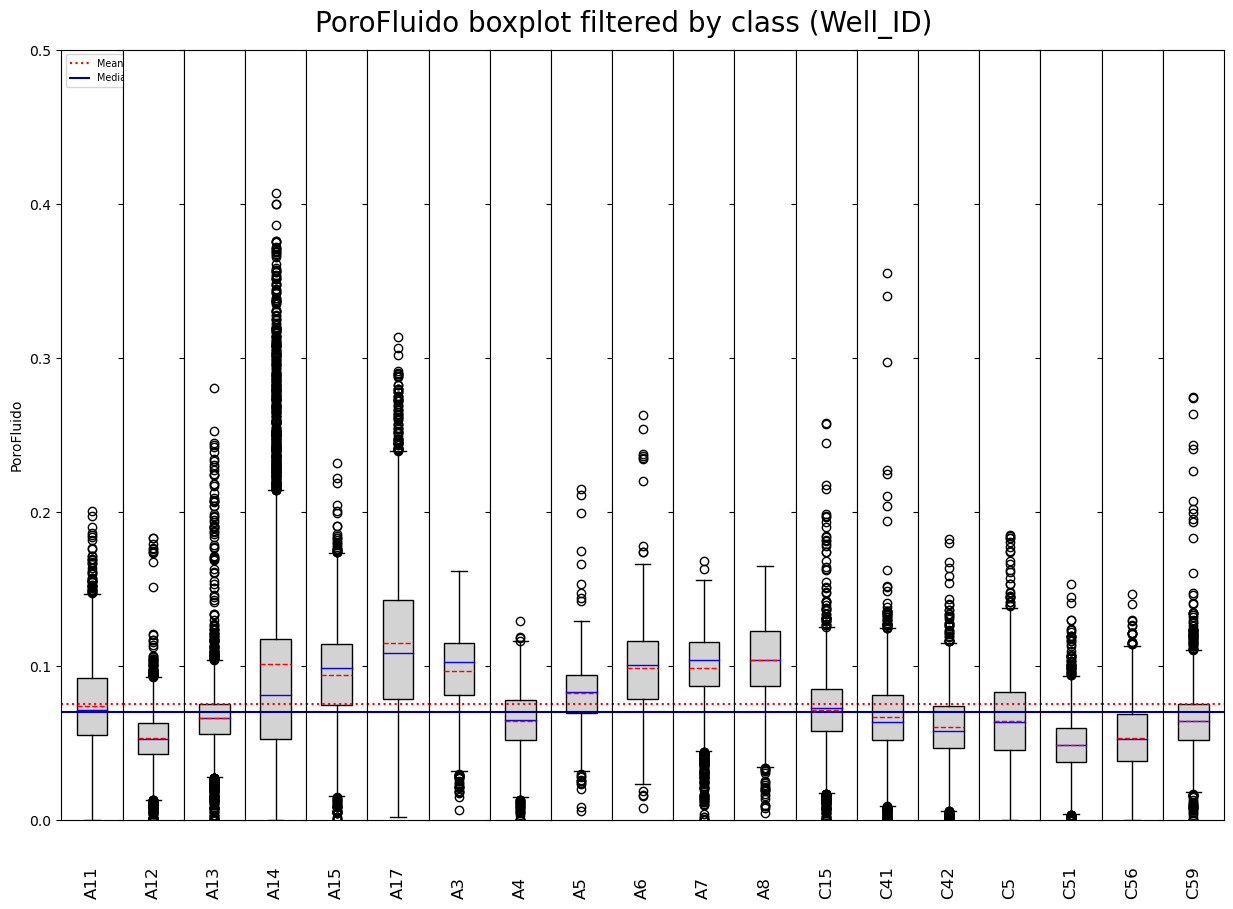

In [17]:
fig, ax = Class_Boxplots_LargeDF(df_CHTC,'PoroFluido', 'Well_ID',Limits=[0,0.5], figsize=[15,10],median=True,mean=True)
#fig.savefig('test.png')

## Feature Selection

In [18]:
f_statistics, p_values = f_regression(df_CHTC[well_logs], df_CHTC['PoroFluido'])
d = {'label': df_CHTC[well_logs].columns, 'f_statistics': f_statistics}
f_df = pd.DataFrame(data=d)
f_sorted = f_df.sort_values(by=['f_statistics'], ascending=False)
f_sorted;

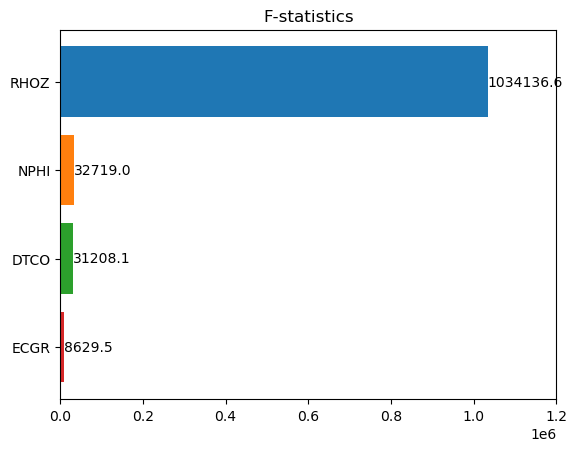

In [19]:
fig, ax = plt.subplots()
#class_plot = ax.barh(df_recortado[registros].columns, f_statistics, color=mcolors.TABLEAU_COLORS)
class_plot = ax.barh(f_sorted['label'], f_sorted['f_statistics'], color=mcolors.TABLEAU_COLORS)

ax.set_title('F-statistics')
ax.bar_label(class_plot, fmt='%.1f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=1200000)
plt.show()

In [20]:
mutual_info = mutual_info_regression(df_CHTC[well_logs], df_CHTC['PoroFluido'])
d = {'label': df_CHTC[well_logs].columns, 'mutual_info': mutual_info}
mutual_info_df = pd.DataFrame(data=d)
mutual_info_sorted = mutual_info_df.sort_values(by=['mutual_info'], ascending=False)
mutual_info_sorted;

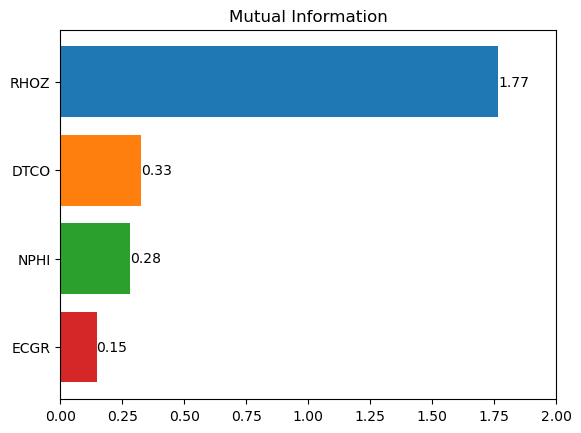

In [21]:
fig, ax = plt.subplots()
class_plot = ax.barh(mutual_info_sorted['label'], mutual_info_sorted['mutual_info'], color=mcolors.TABLEAU_COLORS)
ax.set_title('Mutual Information')
ax.bar_label(class_plot, fmt='%.2f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=2)
plt.show()

## Data Standarization.

Considering the objective is to approach the prediction by splitting the problem into 4 smaller tasks, the standarization was conducted for each one of the Electrofacieses separatedly.

**Global Standarization**

In [22]:
#scaler = StandardScaler()
#df_CHTC_Standard = scaler.fit_transform(df_CHTC_short[well_logs]) 
#df_standard = pd.DataFrame(df_CHTC_Standard, columns=well_logs)
#Estadigrafos(df_standard,['ECGR','AT20','AT90','RHOZ','DTCO','NPHI']).round(2)

**Well to well standarization**

In [23]:
#resultado = []
#scaler = StandardScaler()
#for Well in Prediction_Wells:
#    standarized_data = scaler.fit_transform(df_CHTC[df_CHTC['Well'] == Well][well_logs])
#    resultado = resultado + standarized_data.tolist()
#df_standard = pd.DataFrame(resultado, columns=well_logs, index=df_CHTC[df_CHTC['Well'].isin(Prediction_Wells)].index)
#Estadigrafos(df_standard,['ECGR','AT20','AT90','RHOZ','DTCO','NPHI','PHIT','PHIE','VCL']).round(2)

**Electrofacies standarization**

The database was split into the 4 Electrofacies predicted during the clustering analysis before data standarization.

In [24]:
df_CHTC_PC0 = df_CHTC[df_CHTC['Electrofacies_Class'] == 0]
df_CHTC_PC1 = df_CHTC[df_CHTC['Electrofacies_Class'] == 1]
df_CHTC_PC2 = df_CHTC[df_CHTC['Electrofacies_Class'] == 2]
df_CHTC_PC3 = df_CHTC[df_CHTC['Electrofacies_Class'] == 3]

In [25]:
# Electrofacies 0
scaler_PC0 = StandardScaler()
PC_0_standard = scaler_PC0.fit_transform(df_CHTC_PC0[well_logs]) 
df_CHTC_standard_temp = pd.DataFrame(PC_0_standard, columns=well_logs, index=df_CHTC_PC0.index)
df_CHTC_standard_PC0 = pd.concat([df_CHTC_PC0['DEPT'],df_CHTC_PC0['Well_ID'],df_CHTC_PC0[Target_log],
                              df_CHTC_PC0['Electrofacies_Class'],df_CHTC_standard_temp], axis=1)

# Electrofacies 1
scaler_PC1 = StandardScaler()
PC_1_standard = scaler_PC1.fit_transform(df_CHTC_PC1[well_logs]) 
df_CHTC_standard_temp = pd.DataFrame(PC_1_standard, columns=well_logs, index=df_CHTC_PC1.index)
df_CHTC_standard_PC1 = pd.concat([df_CHTC_PC1['DEPT'],df_CHTC_PC1['Well_ID'],df_CHTC_PC1[Target_log],
                              df_CHTC_PC1['Electrofacies_Class'],df_CHTC_standard_temp], axis=1)

# Electrofacies 2
scaler_PC2 = StandardScaler()
PC_2_standard = scaler_PC2.fit_transform(df_CHTC_PC2[well_logs]) 
df_CHTC_standard_temp = pd.DataFrame(PC_2_standard, columns=well_logs, index=df_CHTC_PC2.index)
df_CHTC_standard_PC2 = pd.concat([df_CHTC_PC2['DEPT'],df_CHTC_PC2['Well_ID'],df_CHTC_PC2[Target_log],
                              df_CHTC_PC2['Electrofacies_Class'],df_CHTC_standard_temp], axis=1)

# Electrofacies 3
scaler_PC3 = StandardScaler()
PC_3_standard = scaler_PC3.fit_transform(df_CHTC_PC3[well_logs]) 
df_CHTC_standard_temp = pd.DataFrame(PC_3_standard, columns=well_logs, index=df_CHTC_PC3.index)
df_CHTC_standard_PC3 = pd.concat([df_CHTC_PC3['DEPT'],df_CHTC_PC3['Well_ID'],df_CHTC_PC3[Target_log],
                              df_CHTC_PC3['Electrofacies_Class'],df_CHTC_standard_temp], axis=1)

In [26]:
# Joint of the individually standarized classses
df_CHTC_standard = pd.concat([df_CHTC_standard_PC0,df_CHTC_standard_PC1,df_CHTC_standard_PC2,df_CHTC_standard_PC3], axis=0)

**Standarized data**

The standarized dataset was split into 4 smaller ones using the Electrofacieses as a filter; this has to be done prior to preparing the train and test datasets for each one of the four Random Forests regressors that will be trained.

In [27]:
#df_CHTC_standard = pd.concat([df_CHTC['DEPT'],df_CHTC['Well'],df_CHTC[Target_log],
#                              df_CHTC['Electrofacies_Predicted'],df_standard], axis=1)
#df_CHTC_standard.dropna(axis=0, inplace=True)
#df_CHTC_standard.head(5)

In [28]:
#df_CHTC_standard_PC0 = df_CHTC_standard[df_CHTC_standard['Electrofacies_Predicted'] == 0]
#df_CHTC_standard_PC1 = df_CHTC_standard[df_CHTC_standard['Electrofacies_Predicted'] == 1]
#df_CHTC_standard_PC2 = df_CHTC_standard[df_CHTC_standard['Electrofacies_Predicted'] == 2]
#df_CHTC_standard_PC3 = df_CHTC_standard[df_CHTC_standard['Electrofacies_Predicted'] == 3]

## Data preparation.

The 19 wells of the area of interest were split into three subsets. The first of said subsets consisted of data used for the training process, the second one consisted of data needed for the testing proccess and the las one consisted of data necesary for the validating process.

**Preliminar well selection**

In order to have a small sample of wells to do the prediction, 1 well was substracted from the dataset; this well will be used later in the prediction section.

In [29]:
Prediction_Wells = ['C42']

In [30]:
df_CHTC_prediction = df_CHTC_standard[df_CHTC_standard['Well_ID'].isin(Prediction_Wells)]
df_CHTC_short = df_CHTC_standard[~ df_CHTC_standard['Well_ID'].isin(Prediction_Wells)]

In [31]:
df_CHTC_PC0 = df_CHTC_short[df_CHTC_short['Electrofacies_Class'] == 0]
df_CHTC_PC1 = df_CHTC_short[df_CHTC_short['Electrofacies_Class'] == 1]
df_CHTC_PC2 = df_CHTC_short[df_CHTC_short['Electrofacies_Class'] == 2]
df_CHTC_PC3 = df_CHTC_short[df_CHTC_short['Electrofacies_Class'] == 3]

**Train-Test split (whole data)**

In [32]:
## Electrofacies 0
X_Train_0, X_Test_0, Y_Train_0, Y_Test_0 = train_test_split(
    df_CHTC_PC0[well_logs], df_CHTC_PC0[Target_log], train_size=0.7, random_state=5)

## Electrofacies 1
X_Train_1, X_Test_1, Y_Train_1, Y_Test_1 = train_test_split(
    df_CHTC_PC1[well_logs], df_CHTC_PC1[Target_log], train_size=0.7, random_state=5)

## Electrofacies 2
X_Train_2, X_Test_2, Y_Train_2, Y_Test_2 = train_test_split(
    df_CHTC_PC2[well_logs], df_CHTC_PC2[Target_log], train_size=0.7, random_state=5)

## Electrofacies 3
X_Train_3, X_Test_3, Y_Train_3, Y_Test_3 = train_test_split(
    df_CHTC_PC3[well_logs], df_CHTC_PC3[Target_log], train_size=0.7, random_state=5)

## Random Forest Regressor

### Electrofacies 0.

In [33]:
start_time = time.time()
RF_Regressor_0 = RandomForestRegressor(n_estimators=20, max_depth=30, criterion='absolute_error', random_state=0)
RF_Regressor_0.fit(X_Train_0.to_numpy(), np.ravel(Y_Train_0.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_0.score(X_Train_0.to_numpy(), Y_Train_0.to_numpy()))

Training time  27.785226583480835 seconds
RF training score:  0.9895075585707814


In [34]:
Y_Test_predicted_0 = pd.DataFrame(RF_Regressor_0.predict(X_Test_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_0.index)

In [35]:
r2_RF_0 = metrics.r2_score(Y_Test_0, Y_Test_predicted_0)
ME_RF_0 = metrics.max_error(Y_Test_0, Y_Test_predicted_0)
MAE_RF_0 = metrics.mean_absolute_error(Y_Test_0, Y_Test_predicted_0)
MSE_RF_0 = metrics.mean_squared_error(Y_Test_0, Y_Test_predicted_0)
medianAE_RF_0 = metrics.median_absolute_error(Y_Test_0, Y_Test_predicted_0)

### Electrofacies 1.

In [36]:
start_time = time.time()
RF_Regressor_1 = RandomForestRegressor(n_estimators=17, max_depth=25, criterion='absolute_error', random_state=0)
RF_Regressor_1.fit(X_Train_1.to_numpy(), np.ravel(Y_Train_1.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_1.score(X_Train_1.to_numpy(), Y_Train_1.to_numpy()))

Training time  35.60374689102173 seconds
RF training score:  0.9692509831544643


In [37]:
Y_Test_predicted_1 = pd.DataFrame(RF_Regressor_1.predict(X_Test_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_1.index)

In [38]:
r2_RF_1 = metrics.r2_score(Y_Test_1, Y_Test_predicted_1)
ME_RF_1 = metrics.max_error(Y_Test_1, Y_Test_predicted_1)
MAE_RF_1 = metrics.mean_absolute_error(Y_Test_1, Y_Test_predicted_1)
MSE_RF_1 = metrics.mean_squared_error(Y_Test_1, Y_Test_predicted_1)
medianAE_RF_1 = metrics.median_absolute_error(Y_Test_1, Y_Test_predicted_1)

### Electrofacies 2.

In [39]:
start_time = time.time()
RF_Regressor_2 = RandomForestRegressor(n_estimators=17, max_depth=30, criterion='absolute_error', random_state=0)
RF_Regressor_2.fit(X_Train_2.to_numpy(), np.ravel(Y_Train_2.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_2.score(X_Train_2.to_numpy(), Y_Train_2.to_numpy()))

Training time  23.2966730594635 seconds
RF training score:  0.9928533581087355


In [40]:
Y_Test_predicted_2 = pd.DataFrame(RF_Regressor_2.predict(X_Test_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_2.index)

In [41]:
r2_RF_2 = metrics.r2_score(Y_Test_2, Y_Test_predicted_2)
ME_RF_2 = metrics.max_error(Y_Test_2, Y_Test_predicted_2)
MAE_RF_2 = metrics.mean_absolute_error(Y_Test_2, Y_Test_predicted_2)
MSE_RF_2 = metrics.mean_squared_error(Y_Test_2, Y_Test_predicted_2)
medianAE_RF_2 = metrics.median_absolute_error(Y_Test_2, Y_Test_predicted_2)

### Electrofacies 3.

In [42]:
start_time = time.time()
RF_Regressor_3 = RandomForestRegressor(n_estimators=12, max_depth=35, criterion='absolute_error', random_state=0)
RF_Regressor_3.fit(X_Train_3.to_numpy(), np.ravel(Y_Train_3.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_3.score(X_Train_3.to_numpy(), Y_Train_3.to_numpy()))

Training time  3.308150053024292 seconds
RF training score:  0.9940021571417085


In [43]:
Y_Test_predicted_3 = pd.DataFrame(RF_Regressor_3.predict(X_Test_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_3.index)

In [44]:
r2_RF_3 = metrics.r2_score(Y_Test_3, Y_Test_predicted_3)
ME_RF_3 = metrics.max_error(Y_Test_3, Y_Test_predicted_3)
MAE_RF_3 = metrics.mean_absolute_error(Y_Test_3, Y_Test_predicted_3)
MSE_RF_3 = metrics.mean_squared_error(Y_Test_3, Y_Test_predicted_3)
medianAE_RF_3 = metrics.median_absolute_error(Y_Test_3, Y_Test_predicted_3)

## Extra Trees Regressor.

### Electrofacies 0.

In [45]:
start_time = time.time()
RFextra_Regressor_0 = ExtraTreesRegressor(n_estimators=20, max_depth=27, criterion='absolute_error', random_state=0)
RFextra_Regressor_0.fit(X_Train_0.to_numpy(), np.ravel(Y_Train_0.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_0.score(X_Train_0.to_numpy(), Y_Train_0.to_numpy()))

Training time  24.599273920059204 seconds
RF training score:  0.9895075585707814


In [46]:
Y_Test_predicted_0 = pd.DataFrame(RFextra_Regressor_0.predict(X_Test_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_0.index)

In [47]:
r2_RFextra_0 = metrics.r2_score(Y_Test_0, Y_Test_predicted_0)
ME_RFextra_0 = metrics.max_error(Y_Test_0, Y_Test_predicted_0)
MAE_RFextra_0 = metrics.mean_absolute_error(Y_Test_0, Y_Test_predicted_0)
MSE_RFextra_0 = metrics.mean_squared_error(Y_Test_0, Y_Test_predicted_0)
medianAE_RFextra_0 = metrics.median_absolute_error(Y_Test_0, Y_Test_predicted_0)

### Electrofacies 1

In [48]:
start_time = time.time()
RFextra_Regressor_1 = ExtraTreesRegressor(n_estimators=22, max_depth=28, criterion='absolute_error', random_state=0)
RFextra_Regressor_1.fit(X_Train_1.to_numpy(), np.ravel(Y_Train_1.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_1.score(X_Train_1.to_numpy(), Y_Train_1.to_numpy()))

Training time  44.54108905792236 seconds
RF training score:  0.9692509831544643


In [49]:
Y_Test_predicted_1 = pd.DataFrame(RFextra_Regressor_1.predict(X_Test_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_1.index)

In [50]:
r2_RFextra_1 = metrics.r2_score(Y_Test_1, Y_Test_predicted_1)
ME_RFextra_1 = metrics.max_error(Y_Test_1, Y_Test_predicted_1)
MAE_RFextra_1 = metrics.mean_absolute_error(Y_Test_1, Y_Test_predicted_1)
MSE_RFextra_1 = metrics.mean_squared_error(Y_Test_1, Y_Test_predicted_1)
medianAE_RFextra_1 = metrics.median_absolute_error(Y_Test_1, Y_Test_predicted_1)

### Electrofacies 2

In [51]:
start_time = time.time()
RFextra_Regressor_2 = ExtraTreesRegressor(n_estimators=12, max_depth=30, criterion='absolute_error', random_state=0)
RFextra_Regressor_2.fit(X_Train_2.to_numpy(), np.ravel(Y_Train_2.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_2.score(X_Train_2.to_numpy(), Y_Train_2.to_numpy()))

Training time  16.506649494171143 seconds
RF training score:  0.9928533581087355


In [52]:
Y_Test_predicted_2 = pd.DataFrame(RFextra_Regressor_2.predict(X_Test_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_2.index)

In [53]:
r2_RFextra_2 = metrics.r2_score(Y_Test_2, Y_Test_predicted_2)
ME_RFextra_2 = metrics.max_error(Y_Test_2, Y_Test_predicted_2)
MAE_RFextra_2 = metrics.mean_absolute_error(Y_Test_2, Y_Test_predicted_2)
MSE_RFextra_2 = metrics.mean_squared_error(Y_Test_2, Y_Test_predicted_2)
medianAE_RFextra_2 = metrics.median_absolute_error(Y_Test_2, Y_Test_predicted_2)

### Electrofacies 3

In [54]:
start_time = time.time()
RFextra_Regressor_3 = ExtraTreesRegressor(n_estimators=22, max_depth=15, criterion='absolute_error', random_state=0)
RFextra_Regressor_3.fit(X_Train_3.to_numpy(), np.ravel(Y_Train_3.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_3.score(X_Train_3.to_numpy(), Y_Train_3.to_numpy()))

Training time  6.167499780654907 seconds
RF training score:  0.9940021571417085


In [55]:
Y_Test_predicted_3 = pd.DataFrame(RFextra_Regressor_3.predict(X_Test_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_3.index)

In [56]:
r2_RFextra_3 = metrics.r2_score(Y_Test_3, Y_Test_predicted_3)
ME_RFextra_3 = metrics.max_error(Y_Test_3, Y_Test_predicted_3)
MAE_RFextra_3 = metrics.mean_absolute_error(Y_Test_3, Y_Test_predicted_3)
MSE_RFextra_3 = metrics.mean_squared_error(Y_Test_3, Y_Test_predicted_3)
medianAE_RFextra_3 = metrics.median_absolute_error(Y_Test_3, Y_Test_predicted_3)

## Random Forest + AdaBoost Regressor.

### Electrofacies 0

In [57]:
start_time = time.time()
RFada_Regressor_0 = AdaBoostRegressor(n_estimators=27, loss='linear',learning_rate=0.1, random_state=0)
RFada_Regressor_0.fit(X_Train_0.to_numpy(), np.ravel(Y_Train_0.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_0.score(X_Train_0.to_numpy(), Y_Train_0.to_numpy()))

Training time  0.48969054222106934 seconds
RF training score:  0.9895075585707814


In [58]:
Y_Test_predicted_0 = pd.DataFrame(RFada_Regressor_0.predict(X_Test_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_0.index)

In [59]:
r2_RFada_0 = metrics.r2_score(Y_Test_0, Y_Test_predicted_0)
ME_RFada_0 = metrics.max_error(Y_Test_0, Y_Test_predicted_0)
MAE_RFada_0 = metrics.mean_absolute_error(Y_Test_0, Y_Test_predicted_0)
MSE_RFada_0 = metrics.mean_squared_error(Y_Test_0, Y_Test_predicted_0)
medianAE_RFada_0 = metrics.median_absolute_error(Y_Test_0, Y_Test_predicted_0)

### Electrofacies 1

In [60]:
start_time = time.time()
RFada_Regressor_1 = AdaBoostRegressor(n_estimators=27, loss='linear',learning_rate=0.1, random_state=0)
RFada_Regressor_1.fit(X_Train_1.to_numpy(), np.ravel(Y_Train_1.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_1.score(X_Train_1.to_numpy(), Y_Train_1.to_numpy()))

Training time  0.5465376377105713 seconds
RF training score:  0.9692509831544643


In [61]:
Y_Test_predicted_1 = pd.DataFrame(RFada_Regressor_1.predict(X_Test_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_1.index)

In [62]:
r2_RFada_1 = metrics.r2_score(Y_Test_1, Y_Test_predicted_1)
ME_RFada_1 = metrics.max_error(Y_Test_1, Y_Test_predicted_1)
MAE_RFada_1 = metrics.mean_absolute_error(Y_Test_1, Y_Test_predicted_1)
MSE_RFada_1 = metrics.mean_squared_error(Y_Test_1, Y_Test_predicted_1)
medianAE_RFada_1 = metrics.median_absolute_error(Y_Test_1, Y_Test_predicted_1)

### Electrofacies 2

In [63]:
start_time = time.time()
RFada_Regressor_2 = AdaBoostRegressor(n_estimators=27, loss='linear',learning_rate=0.1, random_state=0)
RFada_Regressor_2.fit(X_Train_2.to_numpy(), np.ravel(Y_Train_2.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_2.score(X_Train_2.to_numpy(), Y_Train_2.to_numpy()))

Training time  0.4258608818054199 seconds
RF training score:  0.9928533581087355


In [64]:
Y_Test_predicted_2 = pd.DataFrame(RFada_Regressor_2.predict(X_Test_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_2.index)

In [65]:
r2_RFada_2 = metrics.r2_score(Y_Test_2, Y_Test_predicted_2)
ME_RFada_2 = metrics.max_error(Y_Test_2, Y_Test_predicted_2)
MAE_RFada_2 = metrics.mean_absolute_error(Y_Test_2, Y_Test_predicted_2)
MSE_RFada_2 = metrics.mean_squared_error(Y_Test_2, Y_Test_predicted_2)
medianAE_RFada_2 = metrics.median_absolute_error(Y_Test_2, Y_Test_predicted_2)

### Electrofacies 3

In [66]:
start_time = time.time()
RFada_Regressor_3 = AdaBoostRegressor(n_estimators=27, loss='linear',learning_rate=0.1, random_state=0)
RFada_Regressor_3.fit(X_Train_3.to_numpy(), np.ravel(Y_Train_3.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_3.score(X_Train_3.to_numpy(), Y_Train_3.to_numpy()))

Training time  0.1795520782470703 seconds
RF training score:  0.9940021571417085


In [67]:
Y_Test_predicted_3 = pd.DataFrame(RFada_Regressor_3.predict(X_Test_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_3.index)

In [68]:
r2_RFada_3 = metrics.r2_score(Y_Test_3, Y_Test_predicted_3)
ME_RFada_3 = metrics.max_error(Y_Test_3, Y_Test_predicted_3)
MAE_RFada_3 = metrics.mean_absolute_error(Y_Test_3, Y_Test_predicted_3)
MSE_RFada_3 = metrics.mean_squared_error(Y_Test_3, Y_Test_predicted_3)
medianAE_RFada_3 = metrics.median_absolute_error(Y_Test_3, Y_Test_predicted_3)

## Random Forest + Bagging Regressor.

### Electrofacies 0

In [69]:
start_time = time.time()
RFbag_Regressor_0 = BaggingRegressor(n_estimators=28, random_state=0)
RFbag_Regressor_0.fit(X_Train_0.to_numpy(), np.ravel(Y_Train_0.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_0.score(X_Train_0.to_numpy(), Y_Train_0.to_numpy()))

Training time  1.1255509853363037 seconds
RF training score:  0.9895075585707814


In [70]:
Y_Test_predicted_0 = pd.DataFrame(RFbag_Regressor_0.predict(X_Test_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_0.index)

In [71]:
r2_RFbag_0 = metrics.r2_score(Y_Test_0, Y_Test_predicted_0)
ME_RFbag_0 = metrics.max_error(Y_Test_0, Y_Test_predicted_0)
MAE_RFbag_0 = metrics.mean_absolute_error(Y_Test_0, Y_Test_predicted_0)
MSE_RFbag_0 = metrics.mean_squared_error(Y_Test_0, Y_Test_predicted_0)
medianAE_RFbag_0 = metrics.median_absolute_error(Y_Test_0, Y_Test_predicted_0)

### Electrofacies 1

In [72]:
start_time = time.time()
RFbag_Regressor_1 = BaggingRegressor(n_estimators=19, random_state=0)
RFbag_Regressor_1.fit(X_Train_1.to_numpy(), np.ravel(Y_Train_1.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_1.score(X_Train_1.to_numpy(), Y_Train_1.to_numpy()))

Training time  0.8497273921966553 seconds
RF training score:  0.9692509831544643


In [73]:
Y_Test_predicted_1 = pd.DataFrame(RFbag_Regressor_1.predict(X_Test_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_1.index)

In [74]:
r2_RFbag_1 = metrics.r2_score(Y_Test_1, Y_Test_predicted_1)
ME_RFbag_1 = metrics.max_error(Y_Test_1, Y_Test_predicted_1)
MAE_RFbag_1 = metrics.mean_absolute_error(Y_Test_1, Y_Test_predicted_1)
MSE_RFbag_1 = metrics.mean_squared_error(Y_Test_1, Y_Test_predicted_1)
medianAE_RFbag_1 = metrics.median_absolute_error(Y_Test_1, Y_Test_predicted_1)

### Electrofacies 2

In [75]:
start_time = time.time()
RFbag_Regressor_2 = BaggingRegressor(n_estimators=24, random_state=0)
RFbag_Regressor_2.fit(X_Train_2.to_numpy(), np.ravel(Y_Train_2.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_2.score(X_Train_2.to_numpy(), Y_Train_2.to_numpy()))

Training time  0.8567070960998535 seconds
RF training score:  0.9928533581087355


In [76]:
Y_Test_predicted_2 = pd.DataFrame(RFbag_Regressor_2.predict(X_Test_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_2.index)

In [77]:
r2_RFbag_2 = metrics.r2_score(Y_Test_2, Y_Test_predicted_2)
ME_RFbag_2 = metrics.max_error(Y_Test_2, Y_Test_predicted_2)
MAE_RFbag_2 = metrics.mean_absolute_error(Y_Test_2, Y_Test_predicted_2)
MSE_RFbag_2 = metrics.mean_squared_error(Y_Test_2, Y_Test_predicted_2)
medianAE_RFbag_2 = metrics.median_absolute_error(Y_Test_2, Y_Test_predicted_2)

### Electrofacies 3

In [78]:
start_time = time.time()
RFbag_Regressor_3 = BaggingRegressor(n_estimators=23, random_state=0)
RFbag_Regressor_3.fit(X_Train_3.to_numpy(), np.ravel(Y_Train_3.to_numpy()))
finish_time = time.time(); prediction_time = finish_time - start_time
print('Training time ', prediction_time, 'seconds')
print('RF training score: ', RF_Regressor_3.score(X_Train_3.to_numpy(), Y_Train_3.to_numpy()))

Training time  0.3082151412963867 seconds
RF training score:  0.9940021571417085


In [79]:
Y_Test_predicted_3 = pd.DataFrame(RFbag_Regressor_3.predict(X_Test_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Y_Test_3.index)

In [80]:
r2_RFbag_3 = metrics.r2_score(Y_Test_3, Y_Test_predicted_3)
ME_RFbag_3 = metrics.max_error(Y_Test_3, Y_Test_predicted_3)
MAE_RFbag_3 = metrics.mean_absolute_error(Y_Test_3, Y_Test_predicted_3)
MSE_RFbag_3 = metrics.mean_squared_error(Y_Test_3, Y_Test_predicted_3)
medianAE_RFbag_3 = metrics.median_absolute_error(Y_Test_3, Y_Test_predicted_3)

### Metrics

### Electrofacies 0

In [81]:
models_RF_0 = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          'Random Forest':[r2_RF_0,ME_RF_0,MAE_RF_0,MSE_RF_0,medianAE_RF_0],
                         'Random Forest_Extra':[r2_RFextra_0,ME_RFextra_0,MAE_RFextra_0,MSE_RFextra_0,medianAE_RFextra_0],
                         'Random Forest AdaBoost':[r2_RFada_0,ME_RFada_0,MAE_RFada_0,MSE_RFada_0,medianAE_RFada_0],
                         'Random Forest Bagging':[r2_RFbag_0,ME_RFbag_0,MAE_RFbag_0,MSE_RFbag_0,medianAE_RFbag_0]})
models_RF_0

,Metric,Random Forest,Random Forest_Extra,Random Forest AdaBoost,Random Forest Bagging
0,R2 Determination Coefficient,0.92777,0.92980,0.88779,0.93172
1,Maximum residual error,0.09119,0.09199,0.08903,0.09141
2,Mean absolute error,0.00496,0.00471,0.00990,0.00464
3,Mean squared error,0.00011,0.00011,0.00017,0.00011
4,Median absolute error,0.00172,0.00158,0.00843,0.00162


### Electrofacies 1

In [82]:
models_RF_1 = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          'Random Forest':[r2_RF_1,ME_RF_1,MAE_RF_1,MSE_RF_1,medianAE_RF_1],
                         'Random Forest_Extra':[r2_RFextra_1,ME_RFextra_1,MAE_RFextra_1,MSE_RFextra_1,medianAE_RFextra_1],
                         'Random Forest AdaBoost':[r2_RFada_1,ME_RFada_1,MAE_RFada_1,MSE_RFada_1,medianAE_RFada_1],
                         'Random Forest Bagging':[r2_RFbag_1,ME_RFbag_1,MAE_RFbag_1,MSE_RFbag_1,medianAE_RFbag_1]})
models_RF_1

,Metric,Random Forest,Random Forest_Extra,Random Forest AdaBoost,Random Forest Bagging
0,R2 Determination Coefficient,0.82094,0.82230,0.77956,0.82472
1,Maximum residual error,0.05856,0.05621,0.04740,0.05754
2,Mean absolute error,0.00485,0.00471,0.00752,0.00462
3,Mean squared error,0.00009,0.00009,0.00011,0.00009
4,Median absolute error,0.00182,0.00169,0.00586,0.00164


### Electrofacies 2

In [83]:
models_RF_2 = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          'Random Forest':[r2_RF_2,ME_RF_2,MAE_RF_2,MSE_RF_2,medianAE_RF_2],
                         'Random Forest_Extra':[r2_RFextra_2,ME_RFextra_2,MAE_RFextra_2,MSE_RFextra_2,medianAE_RFextra_2],
                         'Random Forest AdaBoost':[r2_RFada_2,ME_RFada_2,MAE_RFada_2,MSE_RFada_2,medianAE_RFada_2],
                         'Random Forest Bagging':[r2_RFbag_2,ME_RFbag_2,MAE_RFbag_2,MSE_RFbag_2,medianAE_RFbag_2]})
models_RF_2

,Metric,Random Forest,Random Forest_Extra,Random Forest AdaBoost,Random Forest Bagging
0,R2 Determination Coefficient,0.95926,0.95774,0.93134,0.96150
1,Maximum residual error,0.03649,0.03987,0.06187,0.03555
2,Mean absolute error,0.00356,0.00362,0.00559,0.00339
3,Mean squared error,0.00004,0.00004,0.00006,0.00003
4,Median absolute error,0.00191,0.00193,0.00410,0.00181


### Electrofacies 3

In [84]:
models_RF_3 = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          'Random Forest':[r2_RF_3,ME_RF_3,MAE_RF_3,MSE_RF_3,medianAE_RF_3],
                         'Random Forest_Extra':[r2_RFextra_3,ME_RFextra_3,MAE_RFextra_3,MSE_RFextra_3,medianAE_RFextra_3],
                         'Random Forest AdaBoost':[r2_RFada_3,ME_RFada_3,MAE_RFada_3,MSE_RFada_3,medianAE_RFada_3],
                         'Random Forest Bagging':[r2_RFbag_3,ME_RFbag_3,MAE_RFbag_3,MSE_RFbag_3,medianAE_RFbag_3]})
models_RF_3

,Metric,Random Forest,Random Forest_Extra,Random Forest AdaBoost,Random Forest Bagging
0,R2 Determination Coefficient,0.96807,0.97011,0.92450,0.96966
1,Maximum residual error,0.02618,0.02524,0.03398,0.02726
2,Mean absolute error,0.00286,0.00266,0.00500,0.00276
3,Mean squared error,0.00002,0.00002,0.00004,0.00002
4,Median absolute error,0.00189,0.00177,0.00405,0.00183


## Results

In [85]:
Target_well = 'C42'

**Prediction**

In [86]:
Class_0 = df_CHTC_prediction[df_CHTC_prediction['Electrofacies_Class'] == 0][well_logs]
Y_Test_predicted_0 = pd.DataFrame(RFbag_Regressor_0.predict(Class_0.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Class_0.index)

Class_1 = df_CHTC_prediction[df_CHTC_prediction['Electrofacies_Class'] == 1][well_logs]
Y_Test_predicted_1 = pd.DataFrame(RFbag_Regressor_1.predict(Class_1.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Class_1.index)

Class_2 = df_CHTC_prediction[df_CHTC_prediction['Electrofacies_Class'] == 2][well_logs]
Y_Test_predicted_2 = pd.DataFrame(RFbag_Regressor_2.predict(Class_2.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Class_2.index)

Class_3 = df_CHTC_prediction[df_CHTC_prediction['Electrofacies_Class'] == 3][well_logs]
Y_Test_predicted_3 = pd.DataFrame(RFbag_Regressor_3.predict(Class_3.to_numpy()), columns=['{}_Predicted'.format(Target_log)],
                                index=Class_3.index)

In [87]:
Y_Test_predicted = pd.concat([Y_Test_predicted_0,Y_Test_predicted_1,Y_Test_predicted_2,Y_Test_predicted_3],axis=0)
Y_Test_predicted.sort_index(axis=0, inplace=True)

**Plots and metrics**

C:\Users\lopez\AppData\Local\Temp\ipykernel_165972\1373161185.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_temp = df_CHTC[df_CHTC['Well_ID'].isin(Prediction_Wells)].join(Y_Test_predicted)[df_CHTC_prediction['Well_ID'] == Target_well]
C:\Users\lopez\AppData\Local\Temp\ipykernel_165972\1373161185.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[0] = plt.subplot2grid((1,2), (0,0), rowspan = 1, colspan = 1)
C:\Users\lopez\AppData\Local\Temp\ipykernel_165972\1373161185.py:33: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[1] = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey=axes[0])


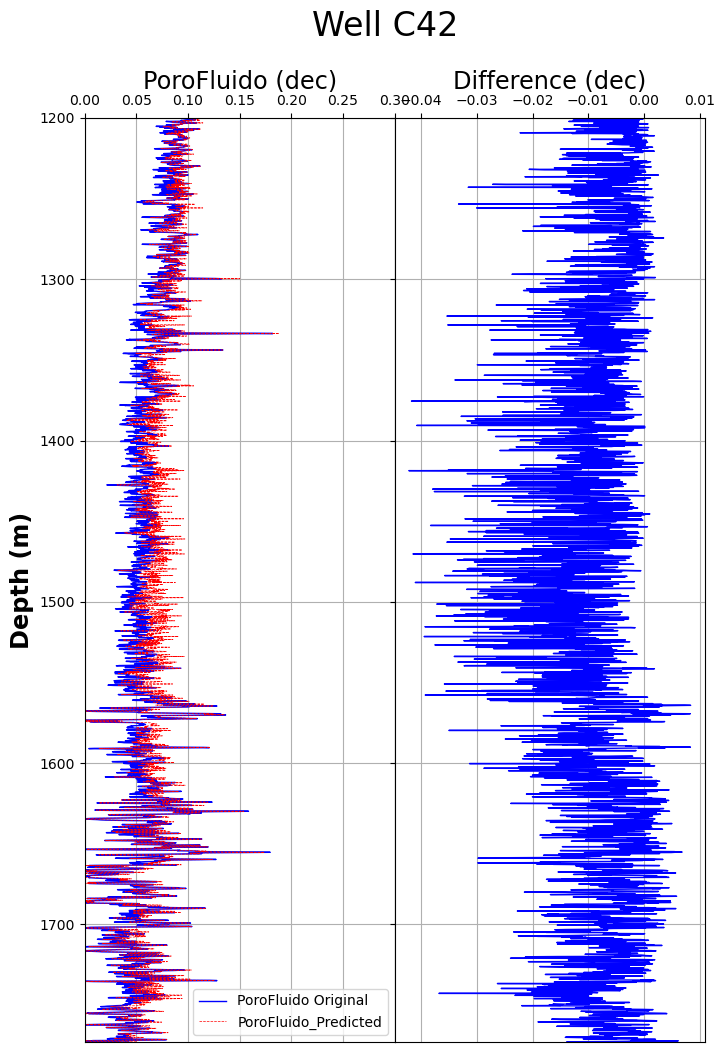

In [88]:
df_temp = df_CHTC[df_CHTC['Well_ID'].isin(Prediction_Wells)].join(Y_Test_predicted)[df_CHTC_prediction['Well_ID'] == Target_well]

## Se deine el tamaño de los carriles, titulo de la grafica y se elimina el espacio entre carriles
fig, axes = plt.subplots(1,2,figsize=[8,12],sharey=True)
fig.suptitle('Well {}'.format(Target_well) ,fontsize=24, x = 0.5, y = 0.97,ha = 'center')
fig.subplots_adjust(wspace = 0.0)

########  Original_log  ################
## Se definen las mallas de la curva que se va a graficar.
axes[0] = plt.subplot2grid((1,2), (0,0), rowspan = 1, colspan = 1)
## Se definen el registro que se va a graficar.
axes[0].plot(df_temp[Target_log], df_temp['DEPT'], c='b', lw=1.0, label='{} Original'.format(Target_log))
## Se establecen los limites de la grafica, tanto el registro como la profundidad.
axes[0].set_xlim(0, 0.3)
axes[0].set_ylim(math.floor(max(df_temp['DEPT'])), math.floor(min(df_temp['DEPT'])))
#axes[0].set_ylim(1500, 2000)
## Se establece la posicion de las escalas.
axes[0].xaxis.set_ticks_position("top"); axes[0].xaxis.set_label_position("top")
## Se define el titulo de cada uno de los carriles.
axes[0].set_ylabel('Depth (m)', fontsize='xx-large',fontweight='bold')
axes[0].set_xlabel('{} (dec)'.format(Target_log), fontsize='xx-large'); axes[0].grid()

########  Regressed Log  #############
## Se definen el registro que se va a graficar.
axes[0].plot(df_temp['{}_Predicted'.format(Target_log)], df_temp['DEPT'],
             color='r',linestyle='dashed',lw=0.5,label='{}_Predicted'.format(Target_log))
#axes[0].axvline(x=df_temp['{}_Predicted'.format(Target_log)].median(), color='green', linestyle='-', label='Mediana')
#axes[0].axvline(x=df_temp['{}_Predicted'.format(Target_log)].mean(),color='r', linestyle=':', label='Media')
axes[0].legend(loc='lower right', fontsize='medium')

#######  Difference  ################
## Se definen las mallas de la curva que se va a graficar.
axes[1] = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan = 1, sharey=axes[0])
## Se definen el registro que se va a graficar.
axes[1].plot(df_temp[Target_log] - df_temp['{}_Predicted'.format(Target_log)], df_temp['DEPT'], c='b', lw=1.0)
## Se establecen los limites de la grafica, tanto el registro como la profundidad.
#axes[1].set_xlim(math.floor(min(df_estimacion['DIF_DTSM'])), math.ceil(max(df_estimacion['DIF_DTSM'])))
## Se establece la posicion de las escalas.
axes[1].xaxis.set_ticks_position("top"); axes[1].xaxis.set_label_position("top")
#axes[1].legend(loc='lower right', fontsize='medium')
#axes[1].spines['top'].set_edgecolor('b')
#axes[1].spines["top"].set_position(('axes',1.05))
## Se define el titulo de cada uno de los carriles.
axes[1].set_xlabel('Difference (dec)', fontsize='xx-large'); axes[1].grid()
plt.setp(axes[1].get_yticklabels(), visible = False);

plt.savefig(currdir + '\Resultados\\PredictedLog.png', format="png", bbox_inches="tight", facecolor='white', dpi=300);

In [89]:
r2_RFbag_pred = metrics.r2_score(df_temp[Target_log], Y_Test_predicted)
ME_RFbag_pred = metrics.max_error(df_temp[Target_log], Y_Test_predicted)
MAE_RFbag_pred = metrics.mean_absolute_error(df_temp[Target_log], Y_Test_predicted)
MSE_RFbag_pred = metrics.mean_squared_error(df_temp[Target_log], Y_Test_predicted)
medianAE_RFbag_pred = metrics.median_absolute_error(df_temp[Target_log], Y_Test_predicted)

In [90]:
Prediction_metrics = pd.DataFrame({'Metric':['R2 Determination Coefficient','Maximum residual error','Mean absolute error',
                                    'Mean squared error','Median absolute error'],
                          Target_well:[r2_RFbag_pred,ME_RFbag_pred,MAE_RFbag_pred,MSE_RFbag_pred,medianAE_RFbag_pred]})
Prediction_metrics

,Metric,C42
0,R2 Determination Coefficient,0.72784
1,Maximum residual error,0.04223
2,Mean absolute error,0.00891
3,Mean squared error,0.00013
4,Median absolute error,0.00757


## Leave-one-out cross-validation.

Once the base predictor had been trained and validated and aimed to delve deeper into the overall performance, the leave-one-out method was conducted. The said method systematically removes one well from the sample before training and validation; this proves the metrics and statistics of the algorithm's performance when small changes are made. Therefore, it helps to understand how robust it is.

The leave-one-out methodology was conducted by casting the code of this NoteBook into a function (the standardisation, splitting, training and validating snippets) so it would work, leaving one well out. The function is then inserted in a loop.

In [91]:
LOO_Wells = [[well for well in Wells if well!=Wells[i]] for i in range(len(Wells))]
Out_well = [[well for well in Wells if well==Wells[i]] for i in range(len(Wells))]
#pd.DataFrame(LOO_Wells)

In [92]:
Training_Metrics0 =[]
Training_Metrics1 =[]
Training_Metrics2 =[]
Training_Metrics3 =[]
Prediction_Metrics = []
#LOO_Wells = LOO_Wells[0:2]

In [93]:
for i in range(len(LOO_Wells)):
    one, two = RF_Batch(df_CHTC, well_logs, 'PoroFluido',LOO_Wells[i])
    Training_Metrics0.append(one[0])
    Training_Metrics1.append(one[1])
    Training_Metrics2.append(one[2])
    Training_Metrics3.append(one[3])
    Prediction_Metrics.append(two)

In [94]:
Prediction_Metrics = pd.DataFrame(Prediction_Metrics, columns=
                                  ['R2 Determination Coefficient','Maximum residual error',
                                   'Mean absolute error','Mean squared error','Median absolute error'],
                                  index=pd.DataFrame(Out_well)[0])
Prediction_Metrics.to_csv(currdir + '\\Resultados\\LOO_Metrics.csv', index=True, na_rep='-999.25')
Prediction_Metrics

,R2 Determination Coefficient,Maximum residual error,Mean absolute error,Mean squared error,Median absolute error
0,,,,,
A3,0.97106,0.04158,0.00279,0.00002,0.00194
A4,0.85193,0.04379,0.00443,0.00006,0.00261
A5,0.93516,0.03159,0.00352,0.00002,0.00276
A6,0.98295,0.02876,0.00207,0.00001,0.00139
A7,0.97308,0.02841,0.00298,0.00002,0.00227
A8,0.98676,0.03249,0.00177,0.00001,0.00131
A11,0.96498,0.02643,0.00359,0.00002,0.00266
A12,0.79587,0.04086,0.00525,0.00006,0.00360
A13,0.89707,0.05040,0.00521,0.00006,0.00322


**LOO Statistics**

In [95]:
Estadigrafos(Prediction_Metrics,['R2 Determination Coefficient','Maximum residual error',
                                   'Mean absolute error','Mean squared error','Median absolute error'])#.to_csv(
#    currdir + '\\Resultados\\LOO_Statistics.csv', index=True, na_rep='-999.25')

,R2 Determination Coefficient,Maximum residual error,Mean absolute error,Mean squared error,Median absolute error
Samples,19.00000,19.00000,19.00000,19.00000,19.00000
Minimum,-0.60433,0.02643,0.00177,0.00001,0.00131
1st quartile,0.84267,0.03513,0.00348,0.00002,0.00222
Median,0.95101,0.04106,0.00434,0.00004,0.00266
Mean,0.83268,0.04428,0.00592,0.00012,0.00477
3rd quartile,0.97207,0.04608,0.00523,0.00006,0.00354
Maximum,0.99076,0.09135,0.03520,0.00145,0.03744
Range,1.59508,0.06493,0.03342,0.00144,0.03613
IQR,0.12940,0.01095,0.00175,0.00004,0.00132
Variance,0.12701,0.00026,0.00005,0.00000,0.00006


## Extra

In [96]:
fig, ax = Class_Boxplots_LargeDF(Prediction_Metrics,'NPHI', 'Well_ID',Limits=[0,0.6], figsize=[15,10],median=True,mean=True)

KeyError: 'Well_ID'

In [ ]:
fig, ax = plt.subplots()
#class_plot = ax.barh(df_recortado[registros].columns, f_statistic, color=mcolors.TABLEAU_COLORS)
class_plot = ax.barh(f_sorted['label'], f_sorted['f_statistic'], color=mcolors.TABLEAU_COLORS)

ax.set_title('F-statistic')
ax.bar_label(class_plot, fmt='%.1f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=20000)
plt.show()
#fig.savefig('F-Static.png')